# Autoencoders
Autoencoderele sunt niste retele neuronale speciale care sunt antrenate sa copieze input-ul sau la output. Autoencoderele invata sa compreseze informatia ca apoi sa o reconstruiasca cu cat mai putine pierderi.

### Exemplu 1: Autoencoder simplu

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [6]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Vo folosi un model cu 2 straturi de tip _Dense_:
- un strat encoder, care comprima imaginile intr-un vector 64-dimensional
- un strat decoder care reconstruieste imaginea originala

In [7]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

In [8]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [10]:
autoencoder.fit(
    x_train, x_train,
    epochs=5,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/5
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0162 - val_loss: 0.0124
Epoch 2/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 3/5
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 4/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0092 - val_loss: 0.0092


In [11]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

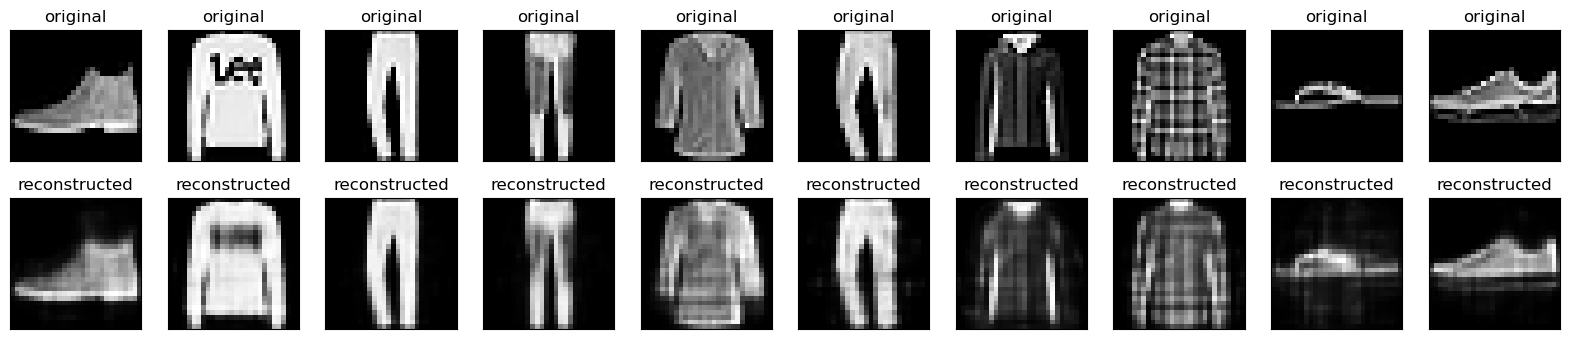

In [12]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Exemplu 2: Image denoising
Putem antrena un autoencoder incat sa stearga zgomotul din imagini.

In [13]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [14]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

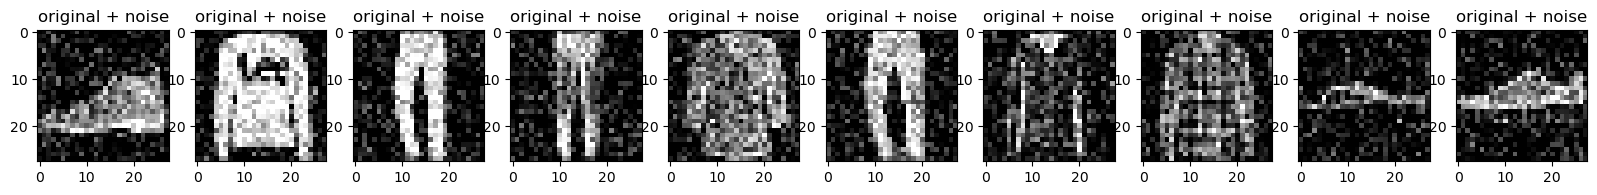

In [15]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [16]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [17]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [18]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=5,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/5
1515/1875 [=======================>......] - ETA: 44s - loss: 0.0210

KeyboardInterrupt: 

In [23]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [26]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [27]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

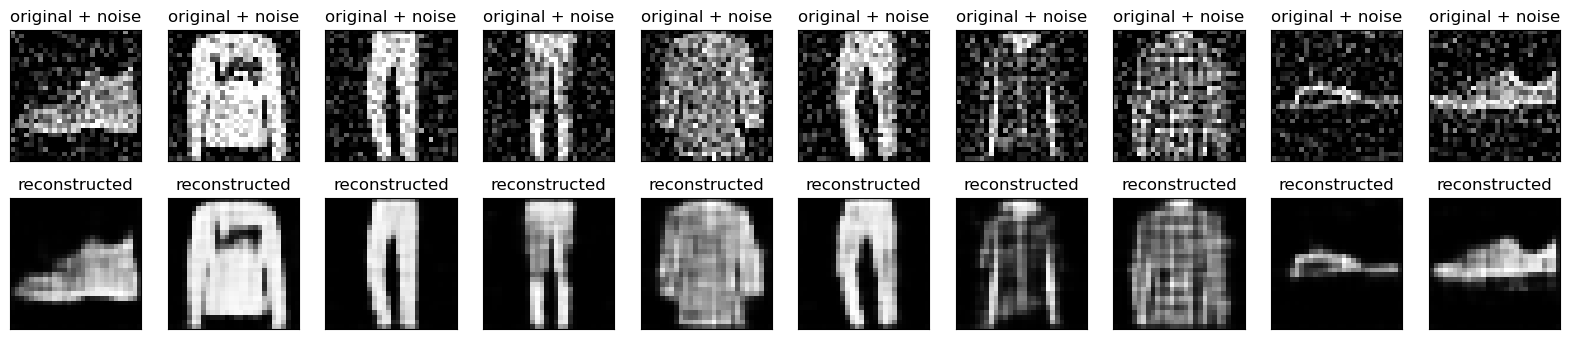

In [28]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()